In [111]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function
import json

In [121]:
class QuadraticCost(object):
   
    @staticmethod
    def cost_fn(a,y):
        return 0.5*np.linalg.norm(a-y)**2
    
    @staticmethod
    def delta(z,a,y):
        return (a-y)*sigmoid_prime(z)
    
    
class CrossentropyCost(object):
    
    @staticmethod
    def cost_fn(a,y):
        return np.sum(np.nan_to_num(-(y*np.log(a))-((1-y)*np.log(1-a))))
    
    @staticmethod
    def delta(z,a,y):
        return a-y
                      
class normalized_weights(object):
                      
    @staticmethod
    def initialize(sizes):
        return [np.random.randn(y,x)/np.sqrt(x) for x,y in zip(sizes[:-1],sizes[1:])]

class default_weights(object):
                      
    @staticmethod
    def initialize(sizes):
        return [np.random.randn(y,x) for x,y in zip(sizes[:-1],sizes[1:])]
                      

class Network(object):
    def __init__(self,sizes,cost=QuadraticCost,initial_weights=default_weights):
        self.n_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(size,1) for size in sizes[1:]]
        self.initial_weights = initial_weights
        self.weights = initial_weights.initialize(sizes)
        self.cost=cost
        
    def feedforward(self,a):
        for b,w in zip(self.biases,self.weights):
            a = sigmoid(np.dot(w,a)+b)
        return a
    
    #stochaistic gradient descent
    def SGD(self, training_data, epoch, mini_batch_size, eta, 
            lamda = None,
            evaluation_data=None, 
            accuracy_graph=False, 
            cost_graph=False):
                      
        if evaluation_data: n_test = len(evaluation_data)
        evaluation_cost, evaluation_accuracy = [], []
        train_cost, train_accuracy = [], []
        n = len(training_data)
        for j in xrange(epoch):
            random.shuffle(training_data)
            mini_batches = [training_data[k:k+mini_batch_size] for k in xrange(0,n,mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, lamda, eta, len(training_data))
            
            if evaluation_data:
                if accuracy_graph:
                      evaluation_accuracy.append(self.accuracy(evaluation_data,convert=False))
                      train_accuracy.append(self.accuracy(training_data,convert=True))
                      
                if cost_graph:
                      evaluation_cost.append(self.total_cost(evaluation_data,lamda,convert=True))
                      train_cost.append(self.total_cost(training_data,lamda,convert=False))
            if j==0:
                print("epoch")
            
            print(j,end=" ")
        if accuracy_graph and evaluation_data:
                line_graph(train_accuracy,evaluation_accuracy,"Accuracy")
                print("\ntraining data accuracy: "+str(train_accuracy[-1]))
                print("evaluation data accuracy: "+str(evaluation_accuracy[-1]))
        if cost_graph and evaluation_data:
                line_graph(train_cost,evaluation_cost,"Cost")
                    
    def update_mini_batch(self, mini_batch, lamda, eta, n):
        #nabla - inverted triangle symbol for slope
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x,y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x,y)
            nabla_b = [nb+dnb for nb,dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw,dnw in zip(nabla_w, delta_nabla_w)]
        if lamda:
            self.biases = [b-(eta/len(mini_batch))*nb for b,nb in zip(self.biases,nabla_b)]
            self.weights = [(1-eta*lamda/n)*w - (eta/len(mini_batch))*nw for w,nw in zip(self.weights,nabla_w)]
        else:
            self.biases = [b-(eta/len(mini_batch))*nb for b,nb in zip(self.biases,nabla_b)]
            self.weights = [w-(eta/len(mini_batch))*nw for w,nw in zip(self.weights,nabla_w)]
        
    def backprop(self, x,y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        activation = x
        activations = [x]
        zs = []
        #forward pass
        
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        
        #backward pass
        delta = (self.cost).delta(zs[-1], activations[-1], y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta,activations[-2].transpose())
        
        for l in xrange(2, self.n_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)
    
    def accuracy(self,data,convert=False):
        if convert:
            results = [(np.argmax(self.feedforward(x)),np.argmax(y)) for x,y in data]
        else:
            results = [(np.argmax(self.feedforward(x)),y) for x,y in data]
        return (float(sum([int(x==y) for x,y in results]))/len(data))*100
                      
    def total_cost(self,data,lamda,convert=False):
        if convert:
            costs = [(self.cost).cost_fn(self.feedforward(x),
                                         vectorized_result(y)) for x,y in data]
        else:
            costs = [(self.cost).cost_fn(self.feedforward(x),y) for x,y in data]
        
        cost = sum(costs)
        cost /= len(data)
        if lamda:
            cost += 0.5*(lamda/len(data))*sum([np.linalg.norm(w)**2 for w in self.weights])
        return cost
    
    def save(self, filename):
        data = {"sizes": self.sizes,
                "weights": [w.tolist() for w in self.weights],
                "biases": [b.tolist() for b in self.biases],
                "cost": str(self.cost.__name__),
                "initial_weights": str(self.initial_weights.__name__)}
        f = open(filename, "w")
        json.dump(data, f)
        f.close()
    
    def get_wrong(self, test_data):
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return [x!=y for (x,y) in test_results]

                      
def load(filename):
    f = open(filename, "r")
    data = json.load(f)
    f.close()
    initial_weights = getattr(sys.modules[__name__], data['initial_weights'])
    cost = getattr(sys.modules[__name__], data["cost"])
    net = Network(data["sizes"], cost=cost)
    net.weights = [np.array(w) for w in data["weights"]]
    net.biases = [np.array(b) for b in data["biases"]]
    return net

def line_graph(t_data,e_data,name):
    fig, ax = plt.subplots()
    ax.plot(range(len(t_data)),t_data,label="Training "+name,color="blue")
    ax.plot(range(len(e_data)),e_data,label="Evaluation "+name,color="red")
    if name=="Accuracy":
        ax.legend(loc=4)
    else:
        ax.legend()
    ax.set_xlabel("epochs")
    ax.set_ylabel(name)
    ax.set_title(name+" graph")
    

#### Miscellaneous functions
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

def vectorized_result(j):
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e
        

        
    

In [83]:
import mnist_loader


In [84]:
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

C:\pers\deep learning\Digit recognizer/mnist.pkl.gz


epoch
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
training data accuracy: 96.192
evaluation data accuracy: 94.72


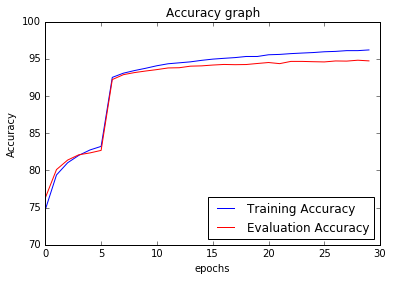

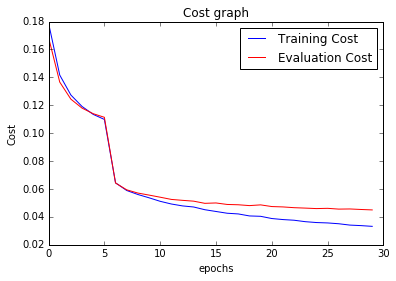

In [109]:
net = Network([784,40,10])
net.SGD(training_data, 30, 10, 0.5,
        evaluation_data=validation_data,
       accuracy_graph=True,
       cost_graph=True)

In [112]:
net.save('simple.json')

epoch
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
training data accuracy: 98.5
evaluation data accuracy: 95.92


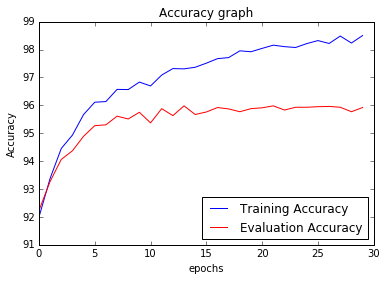

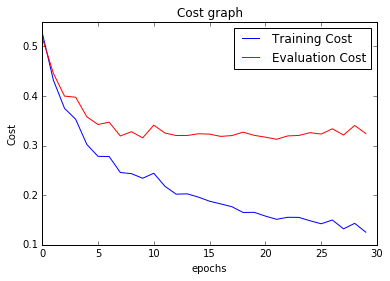

In [116]:
net = Network([784,40,10],cost = CrossentropyCost)
net.SGD(training_data, 30, 10, 0.5,
        evaluation_data=validation_data,
       accuracy_graph=True,
       cost_graph=True)

In [117]:
net.save('simple+CC.json')

epoch
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
training data accuracy: 97.632
evaluation data accuracy: 96.84


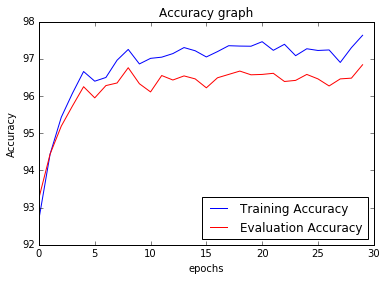

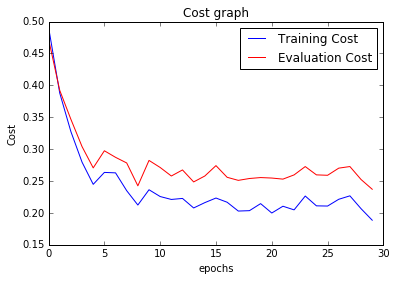

In [118]:
net = Network([784,40,10],cost = CrossentropyCost)
net.SGD(training_data, 30, 10, 0.5,
        evaluation_data=validation_data,
        lamda=5,
       accuracy_graph=True,
       cost_graph=True)

In [119]:
net.save('simple+CC+R.json')

epoch
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
training data accuracy: 97.71
evaluation data accuracy: 96.88


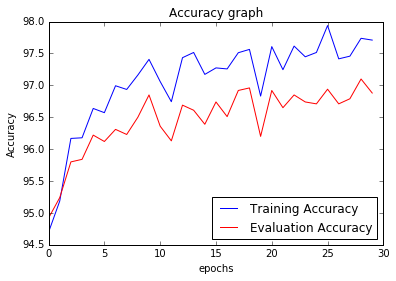

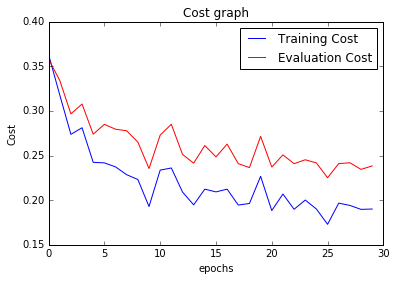

In [123]:
net = Network([784,40,10],
              cost = CrossentropyCost,
              initial_weights = normalized_weights
            )
net.SGD(training_data, 30, 10, 0.5,
        evaluation_data=validation_data,
        lamda=5,
       accuracy_graph=True,
       cost_graph=True)

In [124]:
net.save('simple+CC+R+WI.json')

epoch
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 
training data accuracy: 99.026
evaluation data accuracy: 97.88


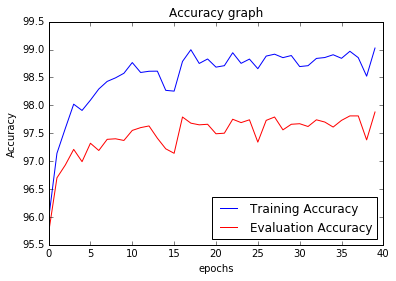

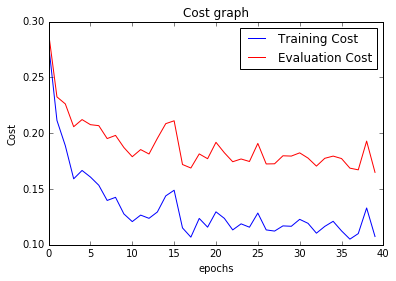

In [125]:
net = Network([784,100,10],
              cost = CrossentropyCost,
              initial_weights = normalized_weights
            )
net.SGD(training_data, 40, 10, 0.5,
        evaluation_data=validation_data,
        lamda=5,
       accuracy_graph=True,
       cost_graph=True)

In [126]:
net.save('simple100+CC+R+WI.json')

epoch
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 
training data accuracy: 98.62
evaluation data accuracy: 97.79


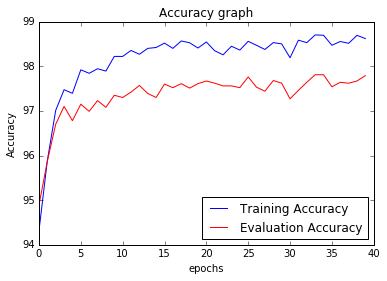

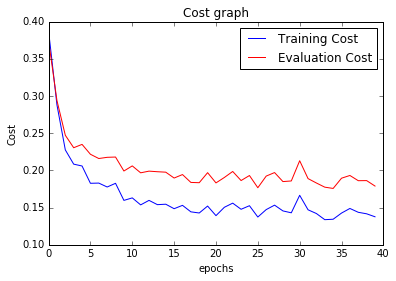

In [128]:
net = Network([784,100,10],
              cost = CrossentropyCost,
              initial_weights = normalized_weights
            )
net.SGD(training_data, 40, 8, 0.2,
        evaluation_data=validation_data,
        lamda=9,
       accuracy_graph=True,
       cost_graph=True)

In [129]:
net.save('simple100+CC+R+WI97.79.json')

epoch
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
training data accuracy: 98.49
evaluation data accuracy: 97.48


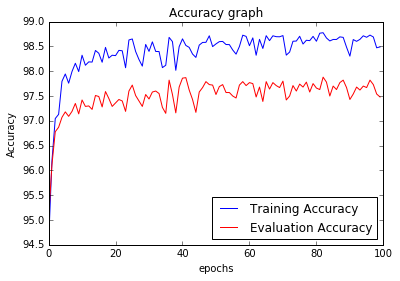

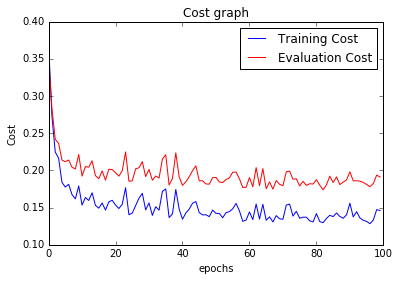

In [130]:
net = Network([784,100,10],
              cost = CrossentropyCost,
              initial_weights = normalized_weights
            )
net.SGD(training_data, 100, 8, 0.2,
        evaluation_data=validation_data,
        lamda=9,
       accuracy_graph=True,
       cost_graph=True)

epoch
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
training data accuracy: 98.734
evaluation data accuracy: 97.81


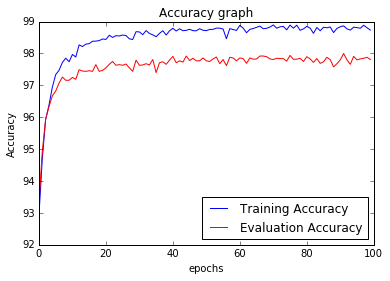

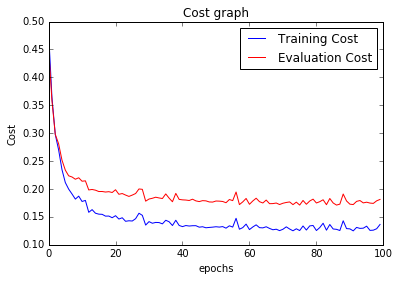

In [131]:
net = Network([784,100,10],
              cost = CrossentropyCost,
              initial_weights = normalized_weights
            )
net.SGD(training_data, 100, 8, 0.1,
        evaluation_data=validation_data,
        lamda=9,
       accuracy_graph=True,
       cost_graph=True)

In [132]:
net.save('simple100+CC+R+WI97.81.json')

epoch
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 
training data accuracy: 98.952
evaluation data accuracy: 97.47


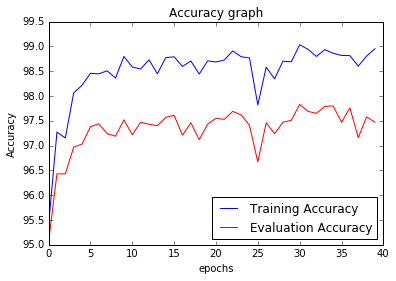

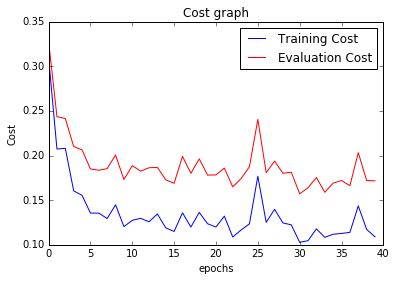

In [140]:
net = Network([784,100,10],
              cost = CrossentropyCost,
              initial_weights = normalized_weights
            )
net.SGD(training_data, 40, 10, 0.5,
        evaluation_data=test_data,
        lamda=5,
       accuracy_graph=True,
       cost_graph=True)

epoch
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
training data accuracy: 98.79
evaluation data accuracy: 97.73


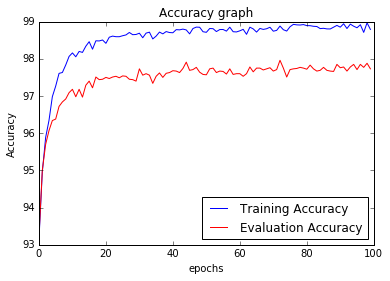

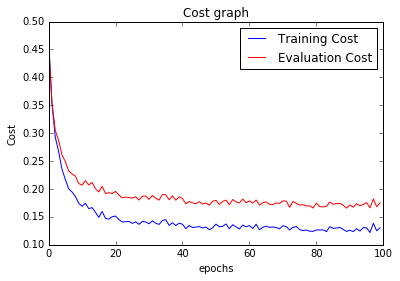

In [133]:
net = Network([784,100,10],
              cost = CrossentropyCost,
              initial_weights = normalized_weights
            )
net.SGD(training_data, 100, 8, 0.1,
        evaluation_data=test_data,
        lamda=9,
       accuracy_graph=True,
       cost_graph=True)

epoch
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 
training data accuracy: 98.138
evaluation data accuracy: 97.33


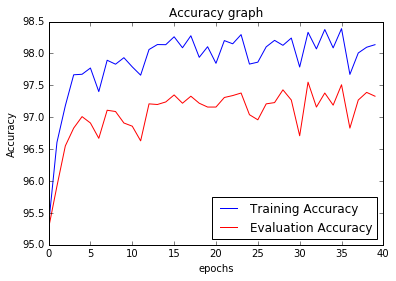

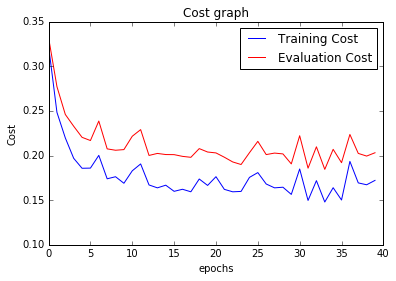

In [135]:
net = Network([784,100,10],
              cost = CrossentropyCost,
              initial_weights = normalized_weights
            )
net.SGD(training_data, 40, 1, 0.05,
        evaluation_data=test_data,
        lamda=9,
       accuracy_graph=True,
       cost_graph=True)

epoch
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
training data accuracy: 98.29
evaluation data accuracy: 97.3


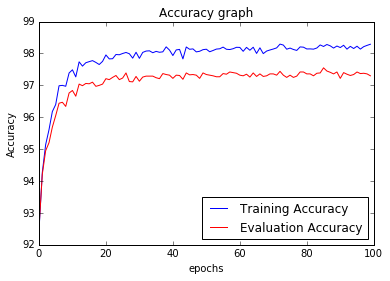

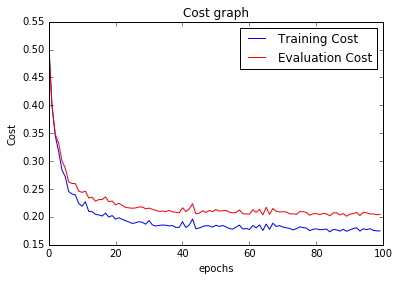

In [136]:
net = Network([784,100,10],
              cost = CrossentropyCost,
              initial_weights = normalized_weights
            )
net.SGD(training_data, 100, 5, 0.05,
        evaluation_data=test_data,
        lamda=15,
       accuracy_graph=True,
       cost_graph=True)

epoch
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
training data accuracy: 97.974
evaluation data accuracy: 97.15


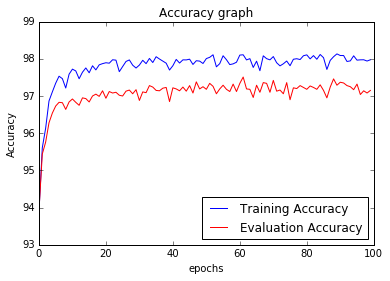

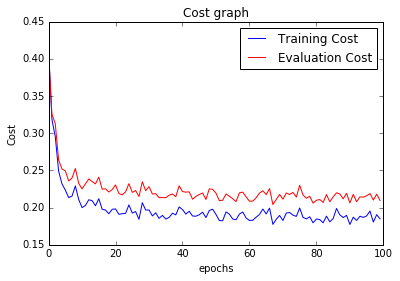

In [137]:
net = Network([784,100,10],
              cost = CrossentropyCost,
              initial_weights = normalized_weights
            )
net.SGD(training_data, 100, 5, 0.1,
        evaluation_data=test_data,
        lamda=15,
       accuracy_graph=True,
       cost_graph=True)

epoch
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
training data accuracy: 98.684
evaluation data accuracy: 97.77


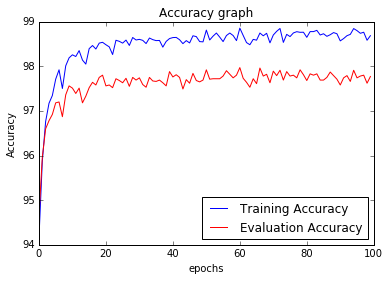

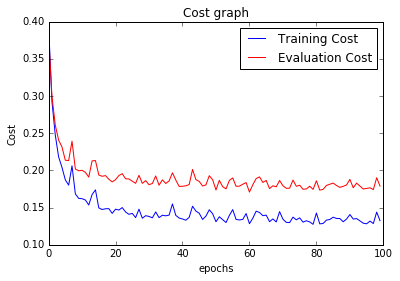

In [138]:
net = Network([784,100,10],
              cost = CrossentropyCost,
              initial_weights = normalized_weights
            )
net.SGD(training_data, 100, 5, 0.1,
        evaluation_data=validation_data,
        lamda=9,
       accuracy_graph=True,
       cost_graph=True)

epoch
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
training data accuracy: 98.432
evaluation data accuracy: 97.55


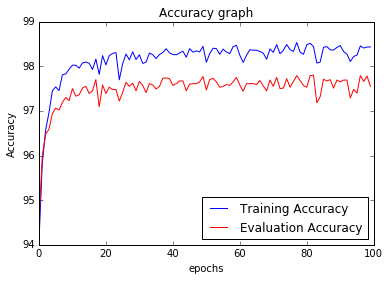

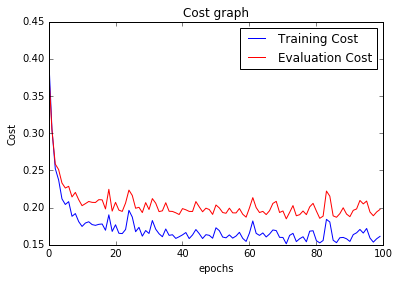

In [139]:
net = Network([784,100,10],
              cost = CrossentropyCost,
              initial_weights = normalized_weights
            )
net.SGD(training_data, 100, 5, 0.1,
        evaluation_data=validation_data,
        lamda=12,
       accuracy_graph=True,
       cost_graph=True)

epoch
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
training data accuracy: 98.92
evaluation data accuracy: 97.83


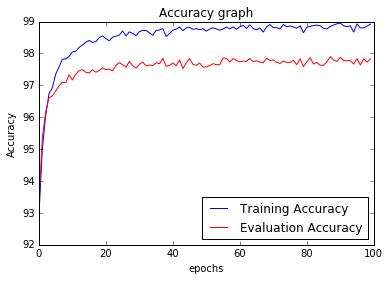

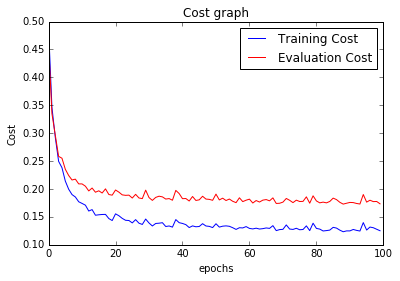

In [141]:
net = Network([784,100,10],
              cost = CrossentropyCost,
              initial_weights = normalized_weights
            )
net.SGD(training_data, 100, 8, 0.1,
        evaluation_data=validation_data,
        lamda=9,
       accuracy_graph=True,
       cost_graph=True)